# Assignment

In [1]:
# Import 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
class Adam:

    def __init__(self, params, beta1=0.9, beta2=0.999, epsilon=1e-8):
        
        self.params = params
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Initialize the momentums.
        self.mt = [np.zeros_like(p) for p in params]
        self.vt = [np.zeros_like(p) for p in params]

        # Initialize the counter.
        self.counter = 0
        
        
    def Compute(self, grads):

        self.counter += 1

        # Update the momentums.
        self.mt = [self.beta1 * mt + (1 - self.beta1) * g for mt, g in zip(self.mt, grads)]

        # Update the variances.
        self.vt = [self.beta2 * vt + (1 - self.beta2) * g**2 for vt, g in zip(self.vt, grads)]

        # Bias-corrected momentums.
        mt_hat = [mt / (1 - self.beta1**self.counter) for mt in self.mt]
        vt_hat = [vt / (1 - self.beta2**self.counter) for vt in self.vt]

        # Compute the Adam updates.
        new_gradients = [mth / (np.sqrt(vth) + self.epsilon) for mth, vth in zip(mt_hat, vt_hat)]

        return new_gradients

In [47]:
class Agent:

    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate, epsilon, beta, gamma, env, algorithm):

        np.random.seed(1)
    
        self.W1 = np.random.randn(input_dim, hidden_dim) / 10
        self.b1 = np.zeros((hidden_dim))
        
        self.W2 = np.random.randn(hidden_dim, output_dim) / 10
        self.b2 = np.zeros((output_dim))

        self.learning_rate = learning_rate
        self.optimizer = Adam([self.W1, self.W2, self.b1, self.b2])

        self.rewards = []
        self.n_of_moves = []
        self.n = 0
        self.epsilon = epsilon
        self.beta = beta
        self.gamma = gamma
        self.env = env
        self.algorithm = algorithm
        self.alpha = 0.99
        self.error = []
        
    def get_action(self, X, epsilon_f, allowed_a):

        qvalues, h_activation = self.forward_prop(X)
        a, _ = np.where(allowed_a==1)

        if np.random.rand() < epsilon_f:
            action = np.random.permutation(a)[0]
        else:
            allowed_qvalues = qvalues[a]
            max_index = np.argmax(allowed_qvalues)
            action = a[max_index]

        return action, qvalues, h_activation

    def forward_prop(self, X):
        h = np.dot(X, self.W1) + self.b1
        # ReLU activation
        h_activation = np.maximum(0, h)
        qvalues = np.dot(h_activation, self.W2) + self.b2

        return qvalues, h_activation

    def backward_prop(self, X, delta2, h_activation):

        dW2 = np.outer(h_activation, delta2)

        delta1 = np.heaviside(h_activation, 0) * np.dot(self.W2, delta2)

        dW1 = np.outer(X, delta1)

        new_gradients = self.optimizer.Compute([dW1, dW2, delta1, delta2])

        self.W1 += self.learning_rate * new_gradients[0]
        self.W2 += self.learning_rate * new_gradients[1]
        self.b1 += self.learning_rate * new_gradients[2]
        self.b2 += self.learning_rate * new_gradients[3]

    def episode(self):
    
        epsilon_f = self.epsilon / (1 + self.beta * self.n)
        policy = epsilon_f if self.algorithm=='sarsa' else 0
        self.n += 1
        Done = 0
        i = 1
        _, X, allowed_a = self.env.Initialise_game()

        while Done==0:
            
            a_agent, qvalues, h_activation = self.get_action(X, epsilon_f, allowed_a)

            _,X_next,allowed_a_next,R,Done=self.env.OneStep(a_agent)

            target = np.copy(qvalues)

            if Done==1:
                target[a_agent] = R
            else:
                a_next, qvalues_next, _ = self.get_action(X_next, policy, allowed_a_next)
                target[a_agent] = R + self.gamma * qvalues_next[a_next]

                X = np.copy(X_next)
                allowed_a = np.copy(allowed_a_next)
                i += 1
            
            error = target - qvalues
            self.error.append(error[a_agent])
            self.backward_prop(X, error, h_activation)


        self.rewards.append(R)
        self.n_of_moves.append(i)

        if self.n % 100 == 0:
            print(f'Episode: {self.n}, Average reward of last 100 eps: {np.mean(self.rewards[-100:]):1.2f}, Number of steps: {np.mean(self.n_of_moves[-100:]):1.2f}')

        return R, i

    def run_training_loop(self, n_of_episodes):

        results = [self.episode() for _ in range(n_of_episodes)]
        Rs, is_ = zip(*results)
        print(f'Average reward: {np.mean(Rs):1.4f}, Number of steps: {np.mean(is_):1.3f}')

    def testing_episode(self):

        epsilon = 0
        Done = 0
        i = 1
        _, X, allowed_a = self.env.Initialise_game()

        a_agent, _, _ = self.get_action(X, epsilon, allowed_a)

        while Done==0 and i<100:
            
            _,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)

            if Done==1:
                break
            else:
                a_next, _, _ = self.get_action(X_next, epsilon, allowed_a_next)

                X = np.copy(X_next)
                a_agent = np.copy(a_next)
                
                i += 1

        return R, i

    def test(self, n_of_episodes):
        results = [self.testing_episode() for _ in range(n_of_episodes)]
        Rs, is_ = zip(*results)
        print(f'Average testing reward: {np.mean(Rs):1.4f}, Number of steps: {np.mean(is_):1.3f}')

In [49]:
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

epsilon_0 = 0.175     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.0005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.005       # THE LEARNING RATE

In [55]:
## INITALISE YOUR NEURAL NETWORK...
qnetwork = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'qlearning')

sarsa = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'sarsa')

In [56]:
qnetwork.run_training_loop(10000)
sarsa.run_training_loop(10000)

Episode: 100, Average reward of last 100 eps: 0.69, Number of steps: 4.60
Episode: 200, Average reward of last 100 eps: 0.73, Number of steps: 5.17
Episode: 300, Average reward of last 100 eps: 0.84, Number of steps: 3.96
Episode: 400, Average reward of last 100 eps: 0.85, Number of steps: 4.31
Episode: 500, Average reward of last 100 eps: 0.87, Number of steps: 4.08
Episode: 600, Average reward of last 100 eps: 0.89, Number of steps: 3.64
Episode: 700, Average reward of last 100 eps: 0.91, Number of steps: 3.53
Episode: 800, Average reward of last 100 eps: 0.87, Number of steps: 3.42
Episode: 900, Average reward of last 100 eps: 0.87, Number of steps: 3.34
Episode: 1000, Average reward of last 100 eps: 0.93, Number of steps: 3.30
Episode: 1100, Average reward of last 100 eps: 0.91, Number of steps: 3.19
Episode: 1200, Average reward of last 100 eps: 0.91, Number of steps: 3.07
Episode: 1300, Average reward of last 100 eps: 0.93, Number of steps: 3.25
Episode: 1400, Average reward of l

In [58]:
q_rewards = qnetwork.rewards
q_n_moves = qnetwork.n_of_moves

print(f'Q-Learning: Episodes: {qnetwork.n: <6}, Average reward: {np.mean(q_rewards):1.4f}, Number of steps: {np.mean(q_n_moves):1.3f}')

q_rewards = pd.Series(q_rewards)
q_n_moves = pd.Series(q_n_moves)

s_rewards = sarsa.rewards
s_n_moves = sarsa.n_of_moves
print(f'SARSA: Episodes: {sarsa.n: <6}, Average reward: {np.mean(s_rewards):1.4f}, Number of steps: {np.mean(s_n_moves):1.3f}')

s_rewards = pd.Series(s_rewards)
s_n_moves = pd.Series(s_n_moves)

Q-Learning: Episodes: 10000 , Average reward: 0.9539, Number of steps: 2.872
SARSA: Episodes: 10000 , Average reward: 0.9408, Number of steps: 2.832


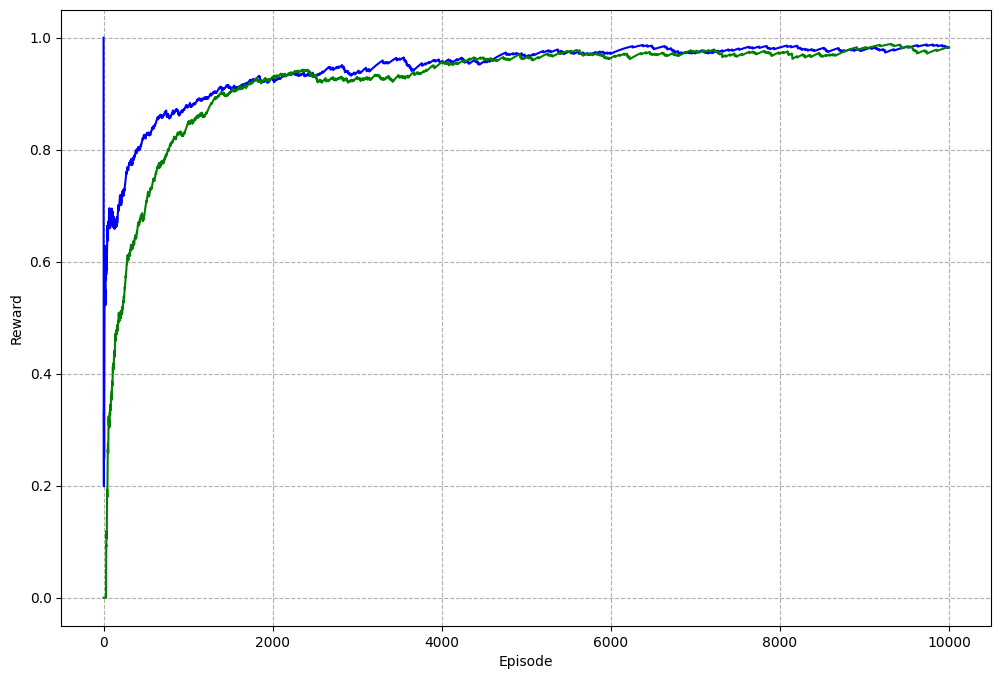

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(q_rewards.ewm(alpha=0.0025).mean(), color='b')
plt.plot(s_rewards.ewm(alpha=0.0025).mean(), color='g')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(axis='x', linestyle='--', markevery=qnetwork.n/10)
plt.grid(axis='y', linestyle='--', markevery=0.2)
plt.show()

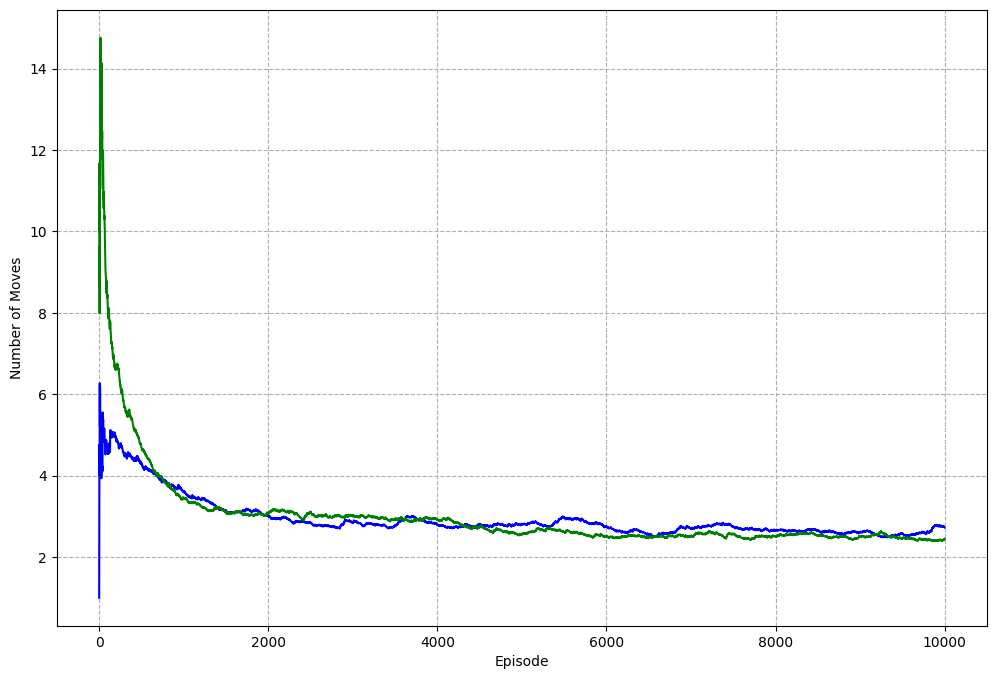

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(q_n_moves.ewm(alpha=0.0025).mean(), color='b')
plt.plot(s_n_moves.ewm(alpha=0.0025).mean(), color='g')
plt.xlabel('Episode')
plt.ylabel('Number of Moves')
plt.grid(axis='x', linestyle='--', markevery=qnetwork.n/10)
plt.grid(axis='y', linestyle='--', markevery=0.2)
plt.show()

In [38]:
## INITALISE YOUR NEURAL NETWORK...
qnetwork1 = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'qlearning')
qnetwork2 = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'qlearning')
qnetwork3 = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'qlearning')

sarsa1 = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'sarsa')
sarsa2 = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'sarsa')
sarsa3 = Agent(N_in, N_h, N_a, eta, epsilon_0, beta, gamma, env, 'sarsa')

In [ ]:
qnetwork1.run_training_loop(10000)
qnetwork2.run_training_loop(10000)
qnetwork3.run_training_loop(10000)
sarsa1.run_training_loop(10000)
sarsa2.run_training_loop(10000)
sarsa3.run_training_loop(10000)

Episode: 100, Average reward of last 100 eps: 0.55, Number of steps: 8.06
Episode: 200, Average reward of last 100 eps: 0.67, Number of steps: 5.95
Episode: 300, Average reward of last 100 eps: 0.77, Number of steps: 4.45
Episode: 400, Average reward of last 100 eps: 0.83, Number of steps: 3.53
Episode: 500, Average reward of last 100 eps: 0.86, Number of steps: 3.07
Episode: 600, Average reward of last 100 eps: 0.85, Number of steps: 3.56
Episode: 700, Average reward of last 100 eps: 0.90, Number of steps: 3.01
Episode: 800, Average reward of last 100 eps: 0.96, Number of steps: 3.26
Episode: 900, Average reward of last 100 eps: 0.93, Number of steps: 2.85
Episode: 1000, Average reward of last 100 eps: 0.93, Number of steps: 3.59
Episode: 1100, Average reward of last 100 eps: 0.89, Number of steps: 3.17
Episode: 1200, Average reward of last 100 eps: 0.96, Number of steps: 3.28
Episode: 1300, Average reward of last 100 eps: 0.96, Number of steps: 2.90
Episode: 1400, Average reward of l

In [46]:
qnetwork1.test(1000)
qnetwork2.test(1000)
qnetwork3.test(1000)
sarsa1.test(1000)
sarsa2.test(1000)
sarsa3.test(1000)

Average testing reward: 0.9960, Number of steps: 2.251
Average testing reward: 0.9850, Number of steps: 2.367
Average testing reward: 0.9670, Number of steps: 2.396
Average testing reward: 0.9980, Number of steps: 2.515
Average testing reward: 0.9740, Number of steps: 2.230
Average testing reward: 0.9930, Number of steps: 2.581


In [ ]:
q_rewards = [np.mean([q1, q2, q3]) for q1, q2, q3 in zip(qnetwork1.rewards, qnetwork2.rewards, qnetwork3.rewards)]
q_n_moves = [np.mean([q1, q2, q3]) for q1, q2, q3 in zip(qnetwork1.n_of_moves, qnetwork2.n_of_moves, qnetwork3.n_of_moves)]

print(f'Q-Learning: Episodes: {qnetwork1.n: <6}, Average reward: {np.mean(q_rewards):1.4f}, Number of steps: {np.mean(q_n_moves):1.3f}')

q_rewards = pd.Series(q_rewards)
q_n_moves = pd.Series(q_n_moves)

s_rewards = [np.mean([s1, s2, s3]) for s1, s2, s3 in zip(sarsa1.rewards, sarsa2.rewards, sarsa3.rewards)]
s_n_moves = [np.mean([s1, s2, s3]) for s1, s2, s3 in zip(sarsa1.n_of_moves, sarsa2.n_of_moves, sarsa3.n_of_moves)]

print(f'SARSA: Episodes: {sarsa1.n: <6}, Average reward: {np.mean(s_rewards):1.4f}, Number of steps: {np.mean(s_n_moves):1.3f}')

s_rewards = pd.Series(s_rewards)
s_n_moves = pd.Series(s_n_moves)

Q-Learning: Episodes: 10000 , Average reward: 0.9490, Number of steps: 2.821
SARSA: Episodes: 10000 , Average reward: 0.9496, Number of steps: 2.738


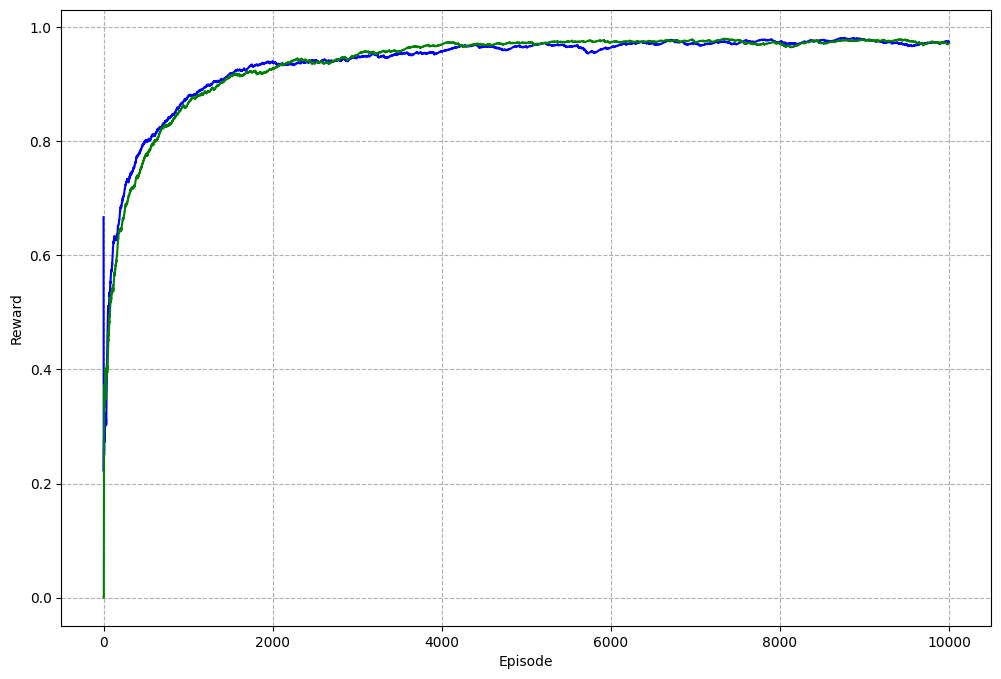

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(q_rewards.ewm(alpha=0.0025).mean(), color='b')
plt.plot(s_rewards.ewm(alpha=0.0025).mean(), color='g')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(axis='x', linestyle='--', markevery=qnetwork1.n/10)
plt.grid(axis='y', linestyle='--', markevery=0.2)
plt.show()

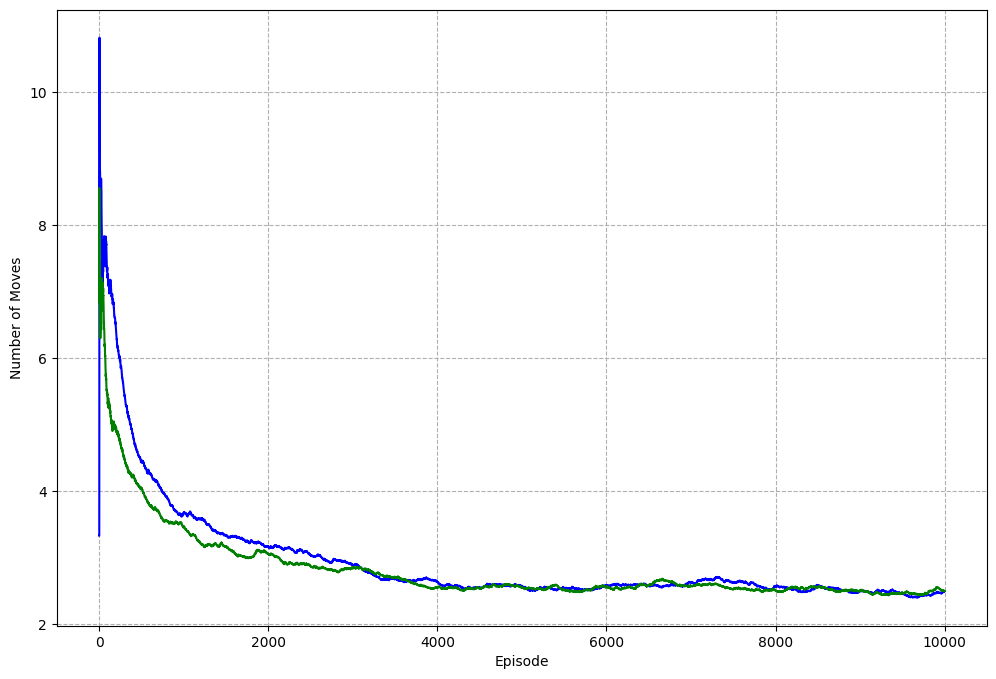

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(q_n_moves.ewm(alpha=0.0025).mean(), color='b')
plt.plot(s_n_moves.ewm(alpha=0.0025).mean(), color='g')
plt.xlabel('Episode')
plt.ylabel('Number of Moves')
plt.grid(axis='x', linestyle='--', markevery=qnetwork1.n/10)
plt.grid(axis='y', linestyle='--', markevery=0.2)
plt.show()